In [ ]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 26.1 MB/s 
     |████████████████████████████████| 596 kB 34.2 MB/s 
     |████████████████████████████████| 3.3 MB 28.8 MB/s 
     |████████████████████████████████| 61 kB 443 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Data Loading

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import gensim
import gensim.downloader as gensim_api
from sklearn.model_selection import train_test_split


In [ ]:
# normalized data
train_score = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/nlp/preprocessed_data/training_set_z_scored.csv')
test_score = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/nlp/preprocessed_data/testing_set_z_scored.csv')

In [ ]:
train_score = train_score.sample(frac=0.2, random_state=6860)
test_score = train_score.sample(frac=0.2, random_state=6860)

In [ ]:
print(test_score.head())
print(train_score.head())
print(test_score.shape)
print(train_score.shape)

                                                    text  ...    z_cool
38563  portland friend gorgeous chinese garden lan su...  ...  0.059461
47306  rating food beverage star rating business prac...  ... -0.329278
50529  firm really piece work guardian sister law nev...  ... -0.781092
28179  place absolute armpit generous fill rental car...  ... -0.178404
56032  one best escape room ever done currently one e...  ...  0.294136

[5 rows x 15 columns]
                                                    text  ...    z_cool
54564  ok pop lock debacle still time show work party...  ...  0.931122
56408  great park right next max stop named lot grass...  ...  0.991397
12671  never visiting salon haircut jessica believe h...  ... -1.255651
66352  finally got visit favorite guitar store visiti...  ...  1.525999
49561  place important enough like make sure set asid...  ...  1.152092

[5 rows x 15 columns]
(2686, 15)
(13428, 15)


In [ ]:
print(test_score['z_cool'])

38563    0.059461
47306   -0.329278
50529   -0.781092
28179   -0.178404
56032    0.294136
           ...   
40895   -1.279439
7523    -0.103538
14076   -1.487705
18138    0.328899
30593   -0.539472
Name: z_cool, Length: 2686, dtype: float64


In [ ]:
print(type(train_score))
print(train_score.iloc[0])

<class 'pandas.core.frame.DataFrame'>
text            ok pop lock debacle still time show work party...
useful                                                         21
funny                                                          15
cool                                                           14
sum_ufc                                                        50
useful_label                                                    1
funny_label                                                     1
cool_label                                                      1
date                                          2010-10-22 18:37:31
date_ymd                                               2010-10-22
days                                                         3770
hund_days                                                      37
z_useful                                                  1.04596
z_funny                                                  0.657965
z_cool                                

In [ ]:
# train_y 
cool_train = train_score['z_cool']
funny_train = train_score['z_funny']
useful_train = train_score['z_useful']
#print(cool[0])
train_y = []
for i,data in train_score.iterrows():
  #print(data)
  temp = []
  temp.append(useful_train[i])
  temp.append(funny_train[i])
  temp.append(cool_train[i])
  #print("temp:", temp)
  train_y.append(temp)

#print(train_y) 

In [ ]:
# test_y
cool_test = test_score['z_cool']
funny_test = test_score['z_funny']
useful_test = test_score['z_useful']
#print(cool[0])
test_y = []
for i,data in test_score.iterrows():
  #print(data)
  temp = []
  temp.append(useful_test[i])
  temp.append(funny_test[i])
  temp.append(cool_test[i])
  #print("temp:", temp)
  test_y.append(temp)

In [ ]:
# preprocessing
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()
def clean_text(texts):
  cleaned_text = texts.copy()
  for index, text in enumerate(texts):
    text = re.sub(r'@[\w]*','',str(text))
    text = re.sub(r'http[^ ]*','',str(text))
    text = re.sub(r'pic.[^ ]*','',str(text))
    text = re.sub(r'[^A-Za-z#]',' ',str(text))
    
    #lowercase
    text = text.lower()
    #tokenization
    text = nltk.word_tokenize(text)
    #remove stopwords
    text = [word for word in text if word not in stopwords]
    # lemmatizing
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    cleaned_text[index] = text
  return cleaned_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_score['text'] = clean_text(train_score['text'])
test_score['text'] = clean_text(test_score['text'])

In [ ]:
# tfidf
tfidf = TfidfVectorizer(max_features = 3000)
training_set_tfidf = tfidf.fit_transform(train_score['text'].values.tolist())
testing_set_tfidf = tfidf.transform(test_score['text'].values.tolist())

In [ ]:
# word2vec
embeddings = gensim_api.load("word2vec-google-news-300")

In [ ]:
# training data embedding
docs_vectors = pd.DataFrame()
stopwords = nltk.corpus.stopwords.words("english")
for doc in train_score["text"]:
  temp = pd.DataFrame()
  for word in doc.split(" "):
    if word not in stopwords:
      try:
        word_vec = embeddings[word]
        temp = temp.append(pd.Series(word_vec), ignore_index = True)
      except:
        pass
  doc_vector = temp.mean()
  docs_vectors = docs_vectors.append(doc_vector, ignore_index = True)
docs_vectors.shape

(13428, 300)

In [ ]:
pd.isnull(docs_vectors).sum().sum()
docs_vectors = docs_vectors.dropna()
training_set_embedding = docs_vectors

In [ ]:
# testing data embedding
docs_vectors = pd.DataFrame()
stopwords = nltk.corpus.stopwords.words("english")
for doc in test_score["text"]:
  temp = pd.DataFrame()
  for word in doc.split(" "):
    if word not in stopwords:
      try:
        word_vec = embeddings[word]
        temp = temp.append(pd.Series(word_vec), ignore_index = True)
      except:
        pass
  doc_vector = temp.mean()
  docs_vectors = docs_vectors.append(doc_vector, ignore_index = True)
docs_vectors.shape

(2686, 300)

In [ ]:
pd.isnull(docs_vectors).sum().sum()
docs_vectors = docs_vectors.dropna()
testing_set_embedding = docs_vectors

In [ ]:
print(testing_set_embedding)
print(training_set_embedding)

           0         1         2    ...       297       298       299
0     0.012474  0.069907  0.002698  ... -0.075924  0.015513  0.032409
1     0.010281  0.016415 -0.028916  ... -0.057701 -0.014277 -0.001898
2     0.025535  0.056227  0.017870  ... -0.055065  0.040710 -0.044825
3     0.019491  0.029193 -0.009717  ... -0.020868 -0.004813 -0.063235
4     0.068119  0.017938 -0.059504  ... -0.022243 -0.019073 -0.033648
...        ...       ...       ...  ...       ...       ...       ...
2681  0.079836  0.009302  0.025647  ...  0.007886  0.018050 -0.056038
2682 -0.028491  0.051119 -0.004145  ... -0.040144  0.034955 -0.002637
2683  0.033278  0.012047  0.016948  ... -0.061873  0.019973 -0.019648
2684 -0.031203  0.044118  0.067716  ... -0.048549  0.055636  0.043456
2685  0.000097  0.011524  0.024283  ... -0.038800  0.057804  0.000502

[2686 rows x 300 columns]
            0         1         2    ...       297       298       299
0      0.030559  0.015056 -0.008597  ... -0.054485  0.029443 -

### Multi-output Regression Algorithm

In [ ]:
# linear regression
from sklearn.linear_model import LinearRegression
model_lr_tfidf = LinearRegression()
model_lr_w2v = LinearRegression()

# tfidf
model_lr_tfidf.fit(training_set_tfidf, train_y)
# w2v
model_lr_w2v.fit(training_set_embedding, train_y)

# prediction
pred_lr_tfidf = model_lr_tfidf.predict(testing_set_tfidf)
pred_lr_w2v = model_lr_w2v.predict(testing_set_embedding)

In [ ]:
# k-nearest
from sklearn.neighbors import KNeighborsRegressor
model_kn_tfidf = KNeighborsRegressor()
model_kn_w2v = KNeighborsRegressor()

# tfidf
model_kn_tfidf.fit(training_set_tfidf, train_y)
# w2v
model_kn_w2v.fit(training_set_embedding, train_y)

# prediction
pred_kn_tfidf = model_kn_tfidf.predict(testing_set_tfidf)
pred_kn_w2v = model_kn_w2v.predict(testing_set_embedding)

In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor
model_rf_tfidf = RandomForestRegressor()
model_rf_w2v = RandomForestRegressor()

# tfidf
model_rf_tfidf.fit(training_set_tfidf, train_y)
# w2v
model_rf_w2v.fit(training_set_embedding, train_y)

# prediction
pred_rf_tfidf = model_rf_tfidf.predict(testing_set_tfidf)
pred_rf_w2v = model_rf_w2v.predict(testing_set_embedding)

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeRegressor
model_dt_tfidf = DecisionTreeRegressor()
model_dt_w2v = DecisionTreeRegressor()

# tfidf
model_dt_tfidf.fit(training_set_tfidf, train_y)
# w2v
model_dt_w2v.fit(training_set_embedding, train_y)

# prediction
pred_dt_tfidf = model_dt_tfidf.predict(testing_set_tfidf)
pred_dt_w2v = model_dt_w2v.predict(testing_set_embedding)

### Wrapper Multi-output Regression Algorithm

In [ ]:
# MultiOutputRegressor with LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
model_svr_tfidf = LinearSVR()
model_svr_w2v = LinearSVR()

# wrapper
wrapper_tfidf = MultiOutputRegressor(model_svr_tfidf)
wrapper_w2v = MultiOutputRegressor(model_svr_w2v)

# tfidf
wrapper_tfidf.fit(training_set_tfidf, train_y)
# w2v
wrapper_w2v.fit(training_set_embedding, train_y)

# prediction
pred_svr_tfidf = wrapper_tfidf.predict(testing_set_tfidf)
pred_svr_w2v = wrapper_w2v.predict(testing_set_embedding)

In [ ]:
# RegressorChain with LinearSVR
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR
model_svr_tfidf_rc = LinearSVR()
model_svr_w2v_rc = LinearSVR()

# wrapper
wrapper_tfidf_rc = MultiOutputRegressor(model_svr_tfidf_rc)
wrapper_w2v_rc = MultiOutputRegressor(model_svr_w2v_rc)

# tfidf
wrapper_tfidf_rc.fit(training_set_tfidf, train_y)
# w2v
wrapper_w2v_rc.fit(training_set_embedding, train_y)

# prediction
pred_svr_tfidf_rc = wrapper_tfidf_rc.predict(testing_set_tfidf)
pred_svr_w2v_rc = wrapper_w2v_rc.predict(testing_set_embedding)

In [ ]:
print("The predicted value example:", pred_dt_tfidf[1])
print("The predicted value example:", pred_lr_tfidf[1])

The predicted value example: [-0.2829669  -0.49124917 -0.32927846]
The predicted value example: [ 0.35266187 -0.35259518 -0.16744851]


In [ ]:
print("The actual value example:", test_y[1])

The actual value example: [-0.2829669  -0.49124917 -0.32927846]


### Evaluation

In [ ]:
# MSE/RMSE/MAE/R-SQUARE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# tfidf
# linear regression
mse_lr_tfidf = mean_squared_error(test_y, pred_lr_tfidf)
rmse_lr_tfidf = mse_lr_tfidf ** 0.5
mae_lr_tfidf = mean_absolute_error(test_y, pred_lr_tfidf)
r2_lr_tfidf = r2_score(test_y, pred_lr_tfidf)
# k-nearest
mse_kn_tfidf = mean_squared_error(test_y, pred_kn_tfidf)
rmse_kn_tfidf = mse_kn_tfidf ** 0.5
mae_kn_tfidf = mean_absolute_error(test_y, pred_kn_tfidf)
r2_kn_tfidf = r2_score(test_y, pred_kn_tfidf)
# random forest
mse_rf_tfidf = mean_squared_error(test_y, pred_rf_tfidf)
rmse_rf_tfidf = mse_rf_tfidf ** 0.5
mae_rf_tfidf = mean_absolute_error(test_y, pred_rf_tfidf)
r2_rf_tfidf = r2_score(test_y, pred_rf_tfidf)
# decision tree
mse_dt_tfidf = mean_squared_error(test_y, pred_dt_tfidf)
rmse_dt_tfidf = mse_dt_tfidf ** 0.5
mae_dt_tfidf = mean_absolute_error(test_y, pred_dt_tfidf)
r2_dt_tfidf = r2_score(test_y, pred_dt_tfidf)
# svr - MultiOutputRegressor
mse_svr_tfidf = mean_squared_error(test_y, pred_svr_tfidf)
rmse_svr_tfidf = mse_svr_tfidf ** 0.5
mae_svr_tfidf = mean_absolute_error(test_y, pred_svr_tfidf)
r2_svr_tfidf = r2_score(test_y, pred_svr_tfidf)
# svr - RegressorChain
mse_svr_tfidf_rc = mean_squared_error(test_y, pred_svr_tfidf_rc)
rmse_svr_tfidf_rc = mse_svr_tfidf_rc ** 0.5
mae_svr_tfidf_rc = mean_absolute_error(test_y, pred_svr_tfidf_rc)
r2_svr_tfidf_rc = r2_score(test_y, pred_svr_tfidf_rc)

# w2v
# linear regression
mse_lr_w2v = mean_squared_error(test_y, pred_lr_w2v)
rmse_lr_w2v = mse_lr_w2v ** 0.5
mae_lr_w2v = mean_absolute_error(test_y, pred_lr_w2v)
r2_lr_w2v = r2_score(test_y, pred_lr_w2v)
# k-nearest
mse_kn_w2v = mean_squared_error(test_y, pred_kn_w2v)
rmse_kn_w2v = mse_kn_w2v ** 0.5
mae_kn_w2v = mean_absolute_error(test_y, pred_kn_w2v)
r2_kn_w2v = r2_score(test_y, pred_kn_w2v)
# random forest
mse_rf_w2v = mean_squared_error(test_y, pred_rf_w2v)
rmse_rf_w2v = mse_rf_w2v ** 0.5
mae_rf_w2v = mean_absolute_error(test_y, pred_rf_w2v)
r2_rf_w2v = r2_score(test_y, pred_rf_w2v)
# decision tree
mse_dt_w2v = mean_squared_error(test_y, pred_dt_w2v)
rmse_dt_w2v = mse_dt_w2v ** 0.5
mae_dt_w2v = mean_absolute_error(test_y, pred_dt_w2v)
r2_dt_w2v = r2_score(test_y, pred_dt_w2v)
# svr - RegressorChain
mse_svr_w2v_rc = mean_squared_error(test_y, pred_svr_w2v_rc)
rmse_svr_w2v_rc = mse_svr_w2v_rc ** 0.5
mae_svr_w2v_rc = mean_absolute_error(test_y, pred_svr_w2v_rc)
r2_svr_w2v_rc = r2_score(test_y, pred_svr_w2v_rc)
# svr - MultiOutputRegressor
mse_svr_w2v = mean_squared_error(test_y, pred_svr_w2v)
rmse_svr_w2v = mse_svr_w2v ** 0.5
mae_svr_w2v = mean_absolute_error(test_y, pred_svr_w2v)
r2_svr_w2v = r2_score(test_y, pred_svr_w2v)

In [ ]:
# Draw table
from prettytable import PrettyTable
performance_table = PrettyTable()

performance_table.field_names = ['Method', 'MSE', 'RMSE', 'MAE', 'R-Squared']
performance_table.add_row(['TFIDF - Linear Regression', 
                            mse_lr_tfidf,
                            rmse_lr_tfidf,
                            mae_lr_tfidf,
                            r2_lr_tfidf])
performance_table.add_row(['Word2Vec - Linear Regression', 
                            mse_lr_w2v,
                            rmse_lr_w2v,
                            mae_lr_w2v,
                            r2_lr_w2v])
performance_table.add_row(['TFIDF - K-Nearest', 
                            mse_kn_tfidf,
                            rmse_kn_tfidf,
                            mae_kn_tfidf,
                            r2_kn_tfidf])
performance_table.add_row(['Word2Vec - K-Nearest', 
                            mse_kn_w2v,
                            rmse_kn_w2v,
                            mae_kn_w2v,
                            r2_kn_w2v])
performance_table.add_row(['TFIDF - Random Forest', 
                            mse_rf_tfidf,
                            rmse_rf_tfidf,
                            mae_rf_tfidf,
                            r2_rf_tfidf])  
performance_table.add_row(['Word2Vec - Random Forest', 
                            mse_rf_w2v,
                            rmse_rf_w2v,
                            mae_rf_w2v,
                            r2_rf_w2v])
performance_table.add_row(['TFIDF - Decision Tree', 
                            mse_dt_tfidf,
                            rmse_dt_tfidf,
                            mae_dt_tfidf,
                            r2_dt_tfidf])
performance_table.add_row(['Word2Vec - Decision Tree', 
                            mse_dt_w2v,
                            rmse_dt_w2v,
                            mae_dt_w2v,
                            r2_dt_w2v])
performance_table.add_row(['TFIDF - SVR(MultiOutputRegressor)', 
                            mse_svr_tfidf,
                            rmse_svr_tfidf,
                            mae_svr_tfidf,
                            r2_svr_tfidf])
performance_table.add_row(['Word2Vec - SVR(MultiOutputRegressor)', 
                            mse_svr_w2v,
                            rmse_svr_w2v,
                            mae_svr_w2v,
                            r2_svr_w2v]) 
performance_table.add_row(['TFIDF - SVR(RegressorChain)', 
                            mse_svr_tfidf_rc,
                            rmse_svr_tfidf_rc,
                            mae_svr_tfidf_rc,
                            r2_svr_tfidf_rc])
performance_table.add_row(['Word2Vec - SVR(RegressorChain)', 
                            mse_svr_w2v_rc,
                            rmse_svr_w2v_rc,
                            mae_svr_w2v_rc,
                            r2_svr_w2v_rc])                           

print(performance_table)

+--------------------------------------+---------------------+--------------------+---------------------+---------------------+
|                Method                |         MSE         |        RMSE        |         MAE         |      R-Squared      |
+--------------------------------------+---------------------+--------------------+---------------------+---------------------+
|      TFIDF - Linear Regression       |  0.6853857979599436 | 0.8278803041261119 |  0.6411115414057668 |  0.3021841300063293 |
|     Word2Vec - Linear Regression     |  0.8325556307210368 | 0.9124448644828008 |  0.6979680816051165 |  0.1524191078393177 |
|          TFIDF - K-Nearest           |  0.7446548296979877 | 0.8629338501287267 |  0.6702153622706692 | 0.24191593378901977 |
|         Word2Vec - K-Nearest         |  0.7639216277423456 | 0.8740261024376478 |  0.6792615413720968 | 0.22227114090446143 |
|        TFIDF - Random Forest         |  0.3566786241916813 |  0.59722577321452  |  0.4096955829560201 

In [ ]:
# Draw table
from prettytable import PrettyTable
performance_table_tfidf = PrettyTable()

performance_table_tfidf.field_names = ['Method', 'MSE', 'RMSE', 'MAE', 'R-Squared']
performance_table_tfidf.add_row(['TFIDF - Linear Regression', 
                            mse_lr_tfidf,
                            rmse_lr_tfidf,
                            mae_lr_tfidf,
                            r2_lr_tfidf])
performance_table_tfidf.add_row(['TFIDF - K-Nearest', 
                            mse_kn_tfidf,
                            rmse_kn_tfidf,
                            mae_kn_tfidf,
                            r2_kn_tfidf])
performance_table_tfidf.add_row(['TFIDF - Random Forest', 
                            mse_rf_tfidf,
                            rmse_rf_tfidf,
                            mae_rf_tfidf,
                            r2_rf_tfidf])  
performance_table_tfidf.add_row(['TFIDF - Decision Tree', 
                            mse_dt_tfidf,
                            rmse_dt_tfidf,
                            mae_dt_tfidf,
                            r2_dt_tfidf])
performance_table_tfidf.add_row(['TFIDF - SVR(MultiOutputRegressor)', 
                            mse_svr_tfidf,
                            rmse_svr_tfidf,
                            mae_svr_tfidf,
                            r2_svr_tfidf])  
performance_table_tfidf.add_row(['TFIDF - SVR(RegressorChain)', 
                            mse_svr_tfidf_rc,
                            rmse_svr_tfidf_rc,
                            mae_svr_tfidf_rc,
                            r2_svr_tfidf_rc])                         

print(performance_table_tfidf)

+-----------------------------------+---------------------+--------------------+--------------------+---------------------+
|               Method              |         MSE         |        RMSE        |        MAE         |      R-Squared      |
+-----------------------------------+---------------------+--------------------+--------------------+---------------------+
|     TFIDF - Linear Regression     |  0.6853857979599436 | 0.8278803041261119 | 0.6411115414057668 |  0.3021841300063293 |
|         TFIDF - K-Nearest         |  0.7446548296979877 | 0.8629338501287267 | 0.6702153622706692 | 0.24191593378901977 |
|       TFIDF - Random Forest       |  0.3566786241916813 |  0.59722577321452  | 0.4096955829560201 |  0.6367505112711895 |
|       TFIDF - Decision Tree       | 0.38215466428350764 | 0.6181865934194203 | 0.2730110347877886 |  0.6108191139659797 |
| TFIDF - SVR(MultiOutputRegressor) |  0.7527118874029148 | 0.8675896999174868 | 0.6004562673472121 | 0.23361113672673514 |
|    TFI

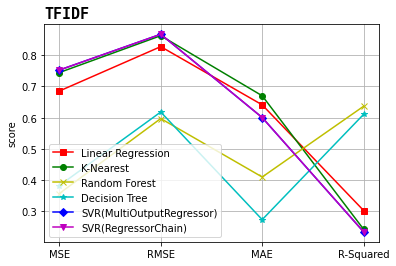

In [12]:
import matplotlib.pyplot as plt

#折线图
names = ['MSE','RMSE','MAE','R-Squared']
x = range(len(names))
lr = [0.6853857979599436,0.8278803041261119,0.6411115414057668,0.3021841300063293]
kn = [0.7446548296979877,0.8629338501287267,0.6702153622706692,0.24191593378901977]
rf = [0.3566786241916813,0.59722577321452,0.4096955829560201,0.6367505112711895]
dt = [0.38215466428350764,0.6181865934194203,0.2730110347877886,0.6108191139659797]
svr_1 = [0.7527118874029148,0.8675896999174868,0.6004562673472121,0.23361113672673514]
svr_2 = [0.7526402373572249,0.8675484063481558,0.60044845086726,0.2336829272385209]
plt.plot(x,lr,'s-',color = 'r',label="Linear Regression")#s-:方形
plt.plot(x,kn,'o-',color = 'g',label="K-Nearest")#o-:圆形
plt.plot(x,rf,'x-',color = 'y',label="Random Forest")
plt.plot(x,dt,'*-',color = 'c',label="Decision Tree")
plt.plot(x,svr_1,'D-',color = 'b',label="SVR(MultiOutputRegressor)")
plt.plot(x,svr_2,'v-',color = 'm',label="SVR(RegressorChain)")

plt.xticks(x,names)
#plt.xlabel("region length")#横坐标名字
plt.ylabel("score")#纵坐标名字
plt.legend(loc = "best")#图例

plt.title("TFIDF", 
          fontdict={'family': 'monospace', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15},
          loc='left')

plt.grid(True)
plt.show()

In [ ]:
# Draw table
from prettytable import PrettyTable
performance_table_w2v = PrettyTable()

performance_table_w2v.field_names = ['Method', 'MSE', 'RMSE', 'MAE', 'R-Squared']
performance_table_w2v.add_row(['Word2Vec - Linear Regression', 
                            mse_lr_w2v,
                            rmse_lr_w2v,
                            mae_lr_w2v,
                            r2_lr_w2v])
performance_table_w2v.add_row(['Word2Vec - K-Nearest', 
                            mse_kn_w2v,
                            rmse_kn_w2v,
                            mae_kn_w2v,
                            r2_kn_w2v]) 
performance_table_w2v.add_row(['Word2Vec - Random Forest', 
                            mse_rf_w2v,
                            rmse_rf_w2v,
                            mae_rf_w2v,
                            r2_rf_w2v])
performance_table_w2v.add_row(['Word2Vec - Decision Tree', 
                            mse_dt_w2v,
                            rmse_dt_w2v,
                            mae_dt_w2v,
                            r2_dt_w2v])
performance_table_w2v.add_row(['Word2Vec - SVR(MultiOutputRegressor)', 
                            mse_svr_w2v,
                            rmse_svr_w2v,
                            mae_svr_w2v,
                            r2_svr_w2v]) 
performance_table_w2v.add_row(['Word2Vec - SVR(RegressorChain)', 
                            mse_svr_w2v_rc,
                            rmse_svr_w2v_rc,
                            mae_svr_w2v_rc,
                            r2_svr_w2v_rc])                          

print(performance_table_w2v)

+--------------------------------------+--------------------+--------------------+---------------------+---------------------+
|                Method                |        MSE         |        RMSE        |         MAE         |      R-Squared      |
+--------------------------------------+--------------------+--------------------+---------------------+---------------------+
|     Word2Vec - Linear Regression     | 0.8325556307210368 | 0.9124448644828008 |  0.6979680816051165 |  0.1524191078393177 |
|         Word2Vec - K-Nearest         | 0.7639216277423456 | 0.8740261024376478 |  0.6792615413720968 | 0.22227114090446143 |
|       Word2Vec - Random Forest       | 0.3599642341720213 | 0.5999701944030398 |  0.412263837701742  |  0.6334021816911375 |
|       Word2Vec - Decision Tree       | 0.4215603233905168 | 0.6492767694831818 | 0.28490958987344767 |   0.57060026790459  |
| Word2Vec - SVR(MultiOutputRegressor) | 0.8654279432961328 | 0.9302837971802652 |  0.6791484176277084 | 0.1189

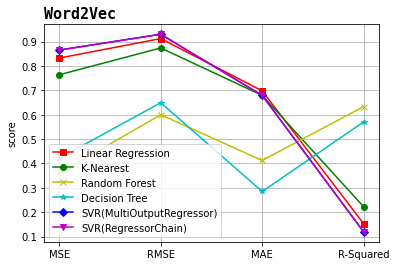

In [13]:
import matplotlib.pyplot as plt

#折线图
names = ['MSE','RMSE','MAE','R-Squared']
x = range(len(names))
lr = [0.8325556307210368,0.9124448644828008,0.6979680816051165,0.1524191078393177]
kn = [0.7639216277423456,0.8740261024376478,0.6792615413720968,0.22227114090446143]
rf = [0.3599642341720213,0.5999701944030398,0.412263837701742,0.6334021816911375]
dt = [0.4215603233905168,0.6492767694831818,0.28490958987344767,0.57060026790459]
svr_1 = [0.8654279432961328,0.9302837971802652,0.6791484176277084,0.11899644439783852]
svr_2 = [0.8651992748144194,0.9301608865214767,0.6790205290254425,0.11924084417762522]
plt.plot(x,lr,'s-',color = 'r',label="Linear Regression")#s-:方形
plt.plot(x,kn,'o-',color = 'g',label="K-Nearest")#o-:圆形
plt.plot(x,rf,'x-',color = 'y',label="Random Forest")
plt.plot(x,dt,'*-',color = 'c',label="Decision Tree")
plt.plot(x,svr_1,'D-',color = 'b',label="SVR(MultiOutputRegressor)")
plt.plot(x,svr_2,'v-',color = 'm',label="SVR(RegressorChain)")

plt.xticks(x,names)
#plt.xlabel("region length")#横坐标名字
plt.ylabel("score")#纵坐标名字
plt.legend(loc = "best")#图例

plt.title("Word2Vec", 
          fontdict={'family': 'monospace', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15},
          loc='left')

plt.grid(True)
plt.show()

In [ ]:
print(type(pred_svr_w2v_rc))
print(type(test_y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
test_useful = test_y[:, 0]
test_funny = test_y[:, 1]
test_cool = test_y[:, 2]

In [ ]:
useful_lr_tfidf = pred_lr_tfidf[:, 0]
funny_lr_tfidf = pred_lr_tfidf[:, 1]
cool_lr_tfidf = pred_lr_tfidf[:, 2]

mse_useful_lr_tfidf = mean_squared_error(test_useful, useful_lr_tfidf)
rmse_useful_lr_tfidf = mse_useful_lr_tfidf ** 0.5
mae_useful_lr_tfidf = mean_absolute_error(test_useful, useful_lr_tfidf)
r2_useful_lr_tfidf = r2_score(test_useful, useful_lr_tfidf)

mse_funny_lr_tfidf = mean_squared_error(test_funny, funny_lr_tfidf)
rmse_funny_lr_tfidf = mse_funny_lr_tfidf ** 0.5
mae_funny_lr_tfidf = mean_absolute_error(test_funny, funny_lr_tfidf)
r2_funny_lr_tfidf = r2_score(test_funny, funny_lr_tfidf)

mse_cool_lr_tfidf = mean_squared_error(test_cool, cool_lr_tfidf)
rmse_cool_lr_tfidf = mse_cool_lr_tfidf ** 0.5
mae_cool_lr_tfidf = mean_absolute_error(test_cool, cool_lr_tfidf)
r2_cool_lr_tfidf = r2_score(test_cool, cool_lr_tfidf)

# Draw table
from prettytable import PrettyTable
performance_table_label_lr_tfidf = PrettyTable()

performance_table_label_lr_tfidf.field_names = ['Method','Label', 'MSE', 'RMSE', 'MAE', 'R-Squared']
performance_table_label_lr_tfidf.add_row(['TFIDF - Linear Regression', 'useful',
                            mse_useful_lr_tfidf,
                            rmse_useful_lr_tfidf,
                            mae_useful_lr_tfidf,
                            r2_useful_lr_tfidf])
performance_table_label_lr_tfidf.add_row(['TFIDF - Linear Regression', 'funny',
                            mse_funny_lr_tfidf,
                            rmse_funny_lr_tfidf,
                            mae_funny_lr_tfidf,
                            r2_funny_lr_tfidf])
performance_table_label_lr_tfidf.add_row(['TFIDF - Linear Regression', 'cool',
                            mse_cool_lr_tfidf,
                            rmse_cool_lr_tfidf,
                            mae_cool_lr_tfidf,
                            r2_cool_lr_tfidf])
print(performance_table_label_lr_tfidf)

+---------------------------+--------+--------------------+--------------------+--------------------+---------------------+
|           Method          | Label  |        MSE         |        RMSE        |        MAE         |      R-Squared      |
+---------------------------+--------+--------------------+--------------------+--------------------+---------------------+
| TFIDF - Linear Regression | useful | 0.7309947190817195 | 0.8549822916772718 | 0.6760122032390765 |  0.2624088261386168 |
| TFIDF - Linear Regression | funny  | 0.6807706765964469 | 0.8250882841226428 | 0.6358222049814012 |  0.311599585303329  |
| TFIDF - Linear Regression |  cool  | 0.644391998201664  | 0.8027403055793723 | 0.611500215996825  | 0.33254397857704276 |
+---------------------------+--------+--------------------+--------------------+--------------------+---------------------+


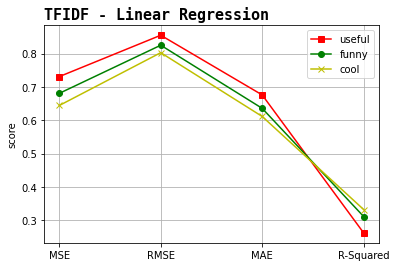

In [14]:
import matplotlib.pyplot as plt

#折线图
names = ['MSE','RMSE','MAE','R-Squared']
x = range(len(names))
useful = [0.7309947190817195,0.8549822916772718,0.6760122032390765,0.2624088261386168]
funny = [0.6807706765964469,0.8250882841226428,0.6358222049814012,0.311599585303329]
cool = [0.644391998201664,0.8027403055793723,0.611500215996825,0.33254397857704276]

plt.plot(x,useful,'s-',color = 'r',label="useful")#s-:方形
plt.plot(x,funny,'o-',color = 'g',label="funny")#o-:圆形
plt.plot(x,cool,'x-',color = 'y',label="cool")

plt.xticks(x,names)
#plt.xlabel("region length")#横坐标名字
plt.ylabel("score")#纵坐标名字
plt.legend(loc = "best")#图例

plt.title("TFIDF - Linear Regression", 
          fontdict={'family': 'monospace', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15},
          loc='left')

plt.grid(True)
plt.show()

In [ ]:
useful_dt_w2v = pred_dt_w2v[:, 0]
funny_dt_w2v = pred_dt_w2v[:, 1]
cool_dt_w2v = pred_dt_w2v[:, 2]

mse_useful_dt_w2v = mean_squared_error(test_useful, useful_dt_w2v)
rmse_useful_dt_w2v = mse_useful_dt_w2v ** 0.5
mae_useful_dt_w2v = mean_absolute_error(test_useful, useful_dt_w2v)
r2_useful_dt_w2v = r2_score(test_useful, useful_dt_w2v)

mse_funny_dt_w2v = mean_squared_error(test_funny, funny_dt_w2v)
rmse_funny_dt_w2v = mse_funny_lr_tfidf ** 0.5
mae_funny_dt_w2v = mean_absolute_error(test_funny, funny_dt_w2v)
r2_funny_dt_w2v = r2_score(test_funny, funny_dt_w2v)

mse_cool_dt_w2v = mean_squared_error(test_cool, cool_dt_w2v)
rmse_cool_dt_w2v = mse_cool_dt_w2v ** 0.5
mae_cool_dt_w2v = mean_absolute_error(test_cool, cool_dt_w2v)
r2_cool_dt_w2v = r2_score(test_cool, cool_dt_w2v)

# Draw table
from prettytable import PrettyTable
performance_table_label_dt_w2v = PrettyTable()

performance_table_label_dt_w2v.field_names = ['Method','Label', 'MSE', 'RMSE', 'MAE', 'R-Squared']
performance_table_label_dt_w2v.add_row(['Word2Vec - Decision Tree', 'useful',
                            mse_useful_dt_w2v,
                            rmse_useful_dt_w2v,
                            mae_useful_dt_w2v,
                            r2_useful_dt_w2v])
performance_table_label_dt_w2v.add_row(['Word2Vec - Decision Tree', 'funny',
                            mse_funny_dt_w2v,
                            rmse_funny_dt_w2v,
                            mae_funny_dt_w2v,
                            r2_funny_dt_w2v])
performance_table_label_dt_w2v.add_row(['Word2Vec - Decision Tree', 'cool',
                            mse_cool_dt_w2v,
                            rmse_cool_dt_w2v,
                            mae_cool_dt_w2v,
                            r2_cool_dt_w2v])
print(performance_table_label_dt_w2v)

+--------------------------+--------+---------------------+--------------------+---------------------+--------------------+
|          Method          | Label  |         MSE         |        RMSE        |         MAE         |     R-Squared      |
+--------------------------+--------+---------------------+--------------------+---------------------+--------------------+
| Word2Vec - Decision Tree | useful | 0.45127936421291354 | 0.6717732982285866 | 0.29681560910000737 | 0.5446483164647726 |
| Word2Vec - Decision Tree | funny  | 0.39322857646312637 | 0.8250882841226428 |  0.2762162708462687 | 0.6023643138374114 |
| Word2Vec - Decision Tree |  cool  | 0.42017302949551055 | 0.648207551248449  | 0.28169688967406664 | 0.5647881734115858 |
+--------------------------+--------+---------------------+--------------------+---------------------+--------------------+


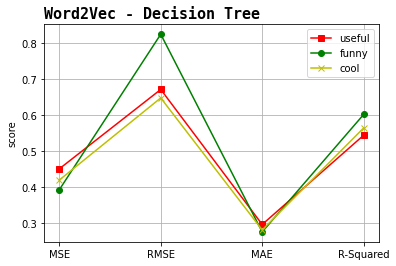

In [15]:
import matplotlib.pyplot as plt

#折线图
names = ['MSE','RMSE','MAE','R-Squared']
x = range(len(names))
useful = [0.45127936421291354,0.6717732982285866,0.29681560910000737,0.5446483164647726]
funny = [0.39322857646312637,0.8250882841226428,0.2762162708462687,0.6023643138374114]
cool = [0.42017302949551055,0.648207551248449,0.28169688967406664,0.5647881734115858]

plt.plot(x,useful,'s-',color = 'r',label="useful")#s-:方形
plt.plot(x,funny,'o-',color = 'g',label="funny")#o-:圆形
plt.plot(x,cool,'x-',color = 'y',label="cool")

plt.xticks(x,names)
#plt.xlabel("region length")#横坐标名字
plt.ylabel("score")#纵坐标名字
plt.legend(loc = "best")#图例

plt.title("Word2Vec - Decision Tree", 
          fontdict={'family': 'monospace', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15},
          loc='left')

plt.grid(True)
plt.show()

In [ ]:
useful_dt_w2v = pred_svr_w2v_rc[:, 0]
funny_dt_w2v = pred_svr_w2v_rc[:, 1]
cool_dt_w2v = pred_svr_w2v_rc[:, 2]

mse_useful_dt_w2v = mean_squared_error(test_useful, useful_dt_w2v)
rmse_useful_dt_w2v = mse_useful_dt_w2v ** 0.5
mae_useful_dt_w2v = mean_absolute_error(test_useful, useful_dt_w2v)
r2_useful_dt_w2v = r2_score(test_useful, useful_dt_w2v)

mse_funny_dt_w2v = mean_squared_error(test_funny, funny_dt_w2v)
rmse_funny_dt_w2v = mse_funny_lr_tfidf ** 0.5
mae_funny_dt_w2v = mean_absolute_error(test_funny, funny_dt_w2v)
r2_funny_dt_w2v = r2_score(test_funny, funny_dt_w2v)

mse_cool_dt_w2v = mean_squared_error(test_cool, cool_dt_w2v)
rmse_cool_dt_w2v = mse_cool_dt_w2v ** 0.5
mae_cool_dt_w2v = mean_absolute_error(test_cool, cool_dt_w2v)
r2_cool_dt_w2v = r2_score(test_cool, cool_dt_w2v)

# Draw table
from prettytable import PrettyTable
performance_table_label_dt_w2v = PrettyTable()

performance_table_label_dt_w2v.field_names = ['Method','Label', 'MSE', 'RMSE', 'MAE', 'R-Squared']
performance_table_label_dt_w2v.add_row(['Word2Vec - SVR(RegressorChain)', 'useful',
                            mse_useful_dt_w2v,
                            rmse_useful_dt_w2v,
                            mae_useful_dt_w2v,
                            r2_useful_dt_w2v])
performance_table_label_dt_w2v.add_row(['Word2Vec - SVR(RegressorChain)', 'funny',
                            mse_funny_dt_w2v,
                            rmse_funny_dt_w2v,
                            mae_funny_dt_w2v,
                            r2_funny_dt_w2v])
performance_table_label_dt_w2v.add_row(['Word2Vec - SVR(RegressorChain)', 'cool',
                            mse_cool_dt_w2v,
                            rmse_cool_dt_w2v,
                            mae_cool_dt_w2v,
                            r2_cool_dt_w2v])
print(performance_table_label_dt_w2v)

+--------------------------------+--------+--------------------+--------------------+--------------------+---------------------+
|             Method             | Label  |        MSE         |        RMSE        |        MAE         |      R-Squared      |
+--------------------------------+--------+--------------------+--------------------+--------------------+---------------------+
| Word2Vec - SVR(RegressorChain) | useful | 0.922821475236321  | 0.9606359743609028 | 0.7264321129814866 | 0.06885103624400013 |
| Word2Vec - SVR(RegressorChain) | funny  | 0.8753397163951009 | 0.8250882841226428 | 0.666003732679292  |  0.1148499127789856 |
| Word2Vec - SVR(RegressorChain) |  cool  | 0.7974366328118356 | 0.8929930754557034 | 0.6446257414155495 | 0.17402158350989128 |
+--------------------------------+--------+--------------------+--------------------+--------------------+---------------------+


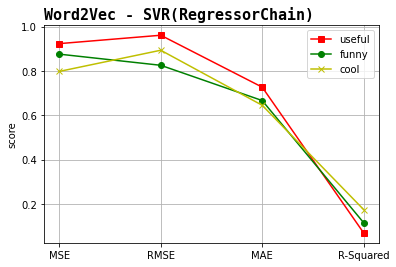

In [16]:
import matplotlib.pyplot as plt

#折线图
names = ['MSE','RMSE','MAE','R-Squared']
x = range(len(names))
useful = [0.922821475236321,0.9606359743609028,0.7264321129814866,0.06885103624400013]
funny = [0.8753397163951009,0.8250882841226428,0.666003732679292,0.1148499127789856]
cool = [0.7974366328118356,0.8929930754557034,0.6446257414155495,0.17402158350989128]

plt.plot(x,useful,'s-',color = 'r',label="useful")#s-:方形
plt.plot(x,funny,'o-',color = 'g',label="funny")#o-:圆形
plt.plot(x,cool,'x-',color = 'y',label="cool")

plt.xticks(x,names)
#plt.xlabel("region length")#横坐标名字
plt.ylabel("score")#纵坐标名字
plt.legend(loc = "best")#图例

plt.title("Word2Vec - SVR(RegressorChain)", 
          fontdict={'family': 'monospace', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 15},
          loc='left')

plt.grid(True)
plt.show()